## Predicting Stress and Sleep Disorders Using Health and Lifestyle Data



## Team
- Bhogaraju Shanmukha Sri Krishna
- Bhupati Varun
- Vishnu Shreeram M P

In [1]:
import sys
import os

# Add project root (one level up from notebooks/) to path
sys.path.append(os.path.abspath(".."))

# Loading Dataset
- To load the dataset, we can use the `read_csv()` function from the pandas library :

```python []
df_part1 = pd.read_csv('./Sleep_health_and_lifestyle_dataset.csv')
df_part2 = pd.read_csv('./Sleep_health_and_lifestyle_dataset_part_2.csv')
```
- These two lines of code will load the dataset from the CSV files `Sleep_health_and_lifestyle_dataset.csv` and `Sleep_health_and_lifestyle_dataset_part_2.csv` respectively and store them in the variables `df_part1` and `df_part2`.
- This logic can be found in ```src/load_data.py```.
- Later the two dfs are merged into a single df and this df is returned.


In [2]:
from src.pre_process import (
    load_data,
    handle_bp,
    categorical_features,
    numeric_features,
    encode,
    standardise,
)

import matplotlib.pyplot as plt

from src.plotting import (
    distr_tgt_feat,
    boxplot,
    correlation_analysis,
    regression_results,
    compute_prec_recall,
    plot_prec_recall,
    plot_residual,
    plot_rfc,
    plot_pca,
    plot_variance_ratio,
)

from src.regression import (
    get_training_scores,
    regress_rf,
    regress_linear,
    regress_bagging,
    compare_regs,
)

from src.classification import classify_svc, compare_clf, classify_rf
from src.sampling import resample_smote, resample_cc, resample_iht
from src.hyperparameter_tuning import run_randomised_search_svc, run_grid_search_svc
from src.decompose import do_pca, get_new_components, get_top_features

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from collections import Counter

from scipy.stats import uniform

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import (
    GradientBoostingRegressor,
    AdaBoostRegressor,
    BaggingRegressor,
)

from xgboost import XGBRegressor, XGBClassifier

from sklearn.ensemble import (
    GradientBoostingClassifier,
    AdaBoostClassifier,
    BaggingClassifier,
)
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline

In [3]:
path1 = "../data/Sleep_health_and_lifestyle_dataset.csv"
path2 = "../data/Sleep_health_and_lifestyle_dataset_part_2.csv"

df = load_data(path1, path2)
df.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


## Exploring the data set

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 560 entries, 0 to 185
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                560 non-null    int64  
 1   Gender                   560 non-null    object 
 2   Age                      560 non-null    int64  
 3   Occupation               560 non-null    object 
 4   Sleep Duration           560 non-null    float64
 5   Quality of Sleep         560 non-null    int64  
 6   Physical Activity Level  560 non-null    int64  
 7   Stress Level             560 non-null    int64  
 8   BMI Category             560 non-null    object 
 9   Blood Pressure           560 non-null    object 
 10  Heart Rate               560 non-null    int64  
 11  Daily Steps              560 non-null    int64  
 12  Sleep Disorder           185 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 61.2+ KB


In [5]:
df.describe()

,Person ID,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps
count,560.000000,560.000000,560.000000,560.000000,560.000000,560.000000,560.000000,560.000000
mean,280.167857,40.021429,7.115893,7.275000,58.787500,5.458929,70.178571,6821.071429
std,161.418024,8.132153,0.742655,1.134631,19.955394,1.676447,3.873247,1527.465518
min,1.000000,27.000000,5.800000,4.000000,30.000000,3.000000,65.000000,3000.000000
25%,140.750000,33.000000,6.500000,6.000000,45.000000,4.000000,68.000000,5500.000000
50%,280.500000,38.000000,7.200000,7.000000,60.000000,5.000000,70.000000,7000.000000
75%,419.250000,44.000000,7.700000,8.000000,75.000000,7.000000,72.000000,8000.000000
max,559.000000,59.000000,8.500000,9.000000,90.000000,8.000000,86.000000,10000.000000


# Dropping Irrelevant Features
- Here, the Person ID feature is irrelevant for our model training. Hence it is dropped
- Note that the drop is done in-place

In [6]:
df = df.drop("Person ID", axis=1)

# Handling NA values  

In [7]:
df.isnull().sum()

Gender                       0
Age                          0
Occupation                   0
Sleep Duration               0
Quality of Sleep             0
Physical Activity Level      0
Stress Level                 0
BMI Category                 0
Blood Pressure               0
Heart Rate                   0
Daily Steps                  0
Sleep Disorder             375
dtype: int64

- NA values found in 'Sleep Disorder' indicates that the person doesn't have any sleep disorders
- so instead of treating it as NA value we will assign 'None' to it

In [8]:
df["Sleep Disorder"] = df["Sleep Disorder"].fillna("None")

In [9]:
df.isnull().sum()

Gender                     0
Age                        0
Occupation                 0
Sleep Duration             0
Quality of Sleep           0
Physical Activity Level    0
Stress Level               0
BMI Category               0
Blood Pressure             0
Heart Rate                 0
Daily Steps                0
Sleep Disorder             0
dtype: int64

In [10]:
df

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,None
1,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
3,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
...,...,...,...,...,...,...,...,...,...,...,...,...
181,Female,43,Teacher,6.7,7,45,4,Overweight,135/90,65,6000,Insomnia
182,Male,43,Salesperson,6.5,6,45,7,Overweight,130/85,72,6000,Insomnia
183,Female,43,Teacher,6.7,7,45,4,Overweight,135/90,65,6000,Insomnia
184,Male,43,Salesperson,6.4,6,45,7,Overweight,130/85,72,6000,Insomnia


## Handling the 'Blood Pressure' column 
- Blood pressure has a systolic and a diastolic pressure in (high/low) format
- Hence, splitting it into Diastolic Pressure and Systolic Pressure

In [11]:
df = handle_bp(df)
df

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,Diastolic Pressure,Systolic Pressure
0,Male,27,Software Engineer,6.1,6,42,6,Overweight,77,4200,None,83,126
1,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,None,80,125
2,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,None,80,125
3,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,90,140
4,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,90,140
...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,Female,43,Teacher,6.7,7,45,4,Overweight,65,6000,Insomnia,90,135
182,Male,43,Salesperson,6.5,6,45,7,Overweight,72,6000,Insomnia,85,130
183,Female,43,Teacher,6.7,7,45,4,Overweight,65,6000,Insomnia,90,135
184,Male,43,Salesperson,6.4,6,45,7,Overweight,72,6000,Insomnia,85,130


## Using LabelEncoders to Encode the Categorical Data
- We also store a dictionary of encoders so that we can also Transform the unseen data into the same format

In [12]:
catData = categorical_features(df)
print("categorical features are :", catData)

categorical features are : ['Gender', 'Occupation', 'BMI Category', 'Sleep Disorder']


In [13]:
numData = numeric_features(df)
print("numeric features are :", numData)

numeric features are : ['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Heart Rate', 'Daily Steps', 'Diastolic Pressure', 'Systolic Pressure']


In [14]:
enc_res = encode(df)
df = enc_res[0]
label_encoding_dict = enc_res[1]
df

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,Diastolic Pressure,Systolic Pressure
0,1,27,9,6.1,6,42,6,3,77,4200,1,83,126
1,1,28,1,6.2,6,60,8,0,75,10000,1,80,125
2,1,28,1,6.2,6,60,8,0,75,10000,1,80,125
3,1,28,6,5.9,4,30,8,2,85,3000,2,90,140
4,1,28,6,5.9,4,30,8,2,85,3000,2,90,140
...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,0,43,10,6.7,7,45,4,3,65,6000,0,90,135
182,1,43,7,6.5,6,45,7,3,72,6000,0,85,130
183,0,43,10,6.7,7,45,4,3,65,6000,0,90,135
184,1,43,7,6.4,6,45,7,3,72,6000,0,85,130


# Distribution of target features

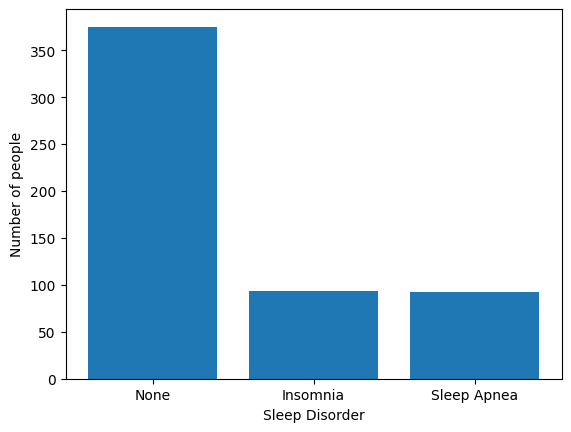

In [15]:
distr_tgt_feat(label_encoding_dict, df)

# Boxplot of Features

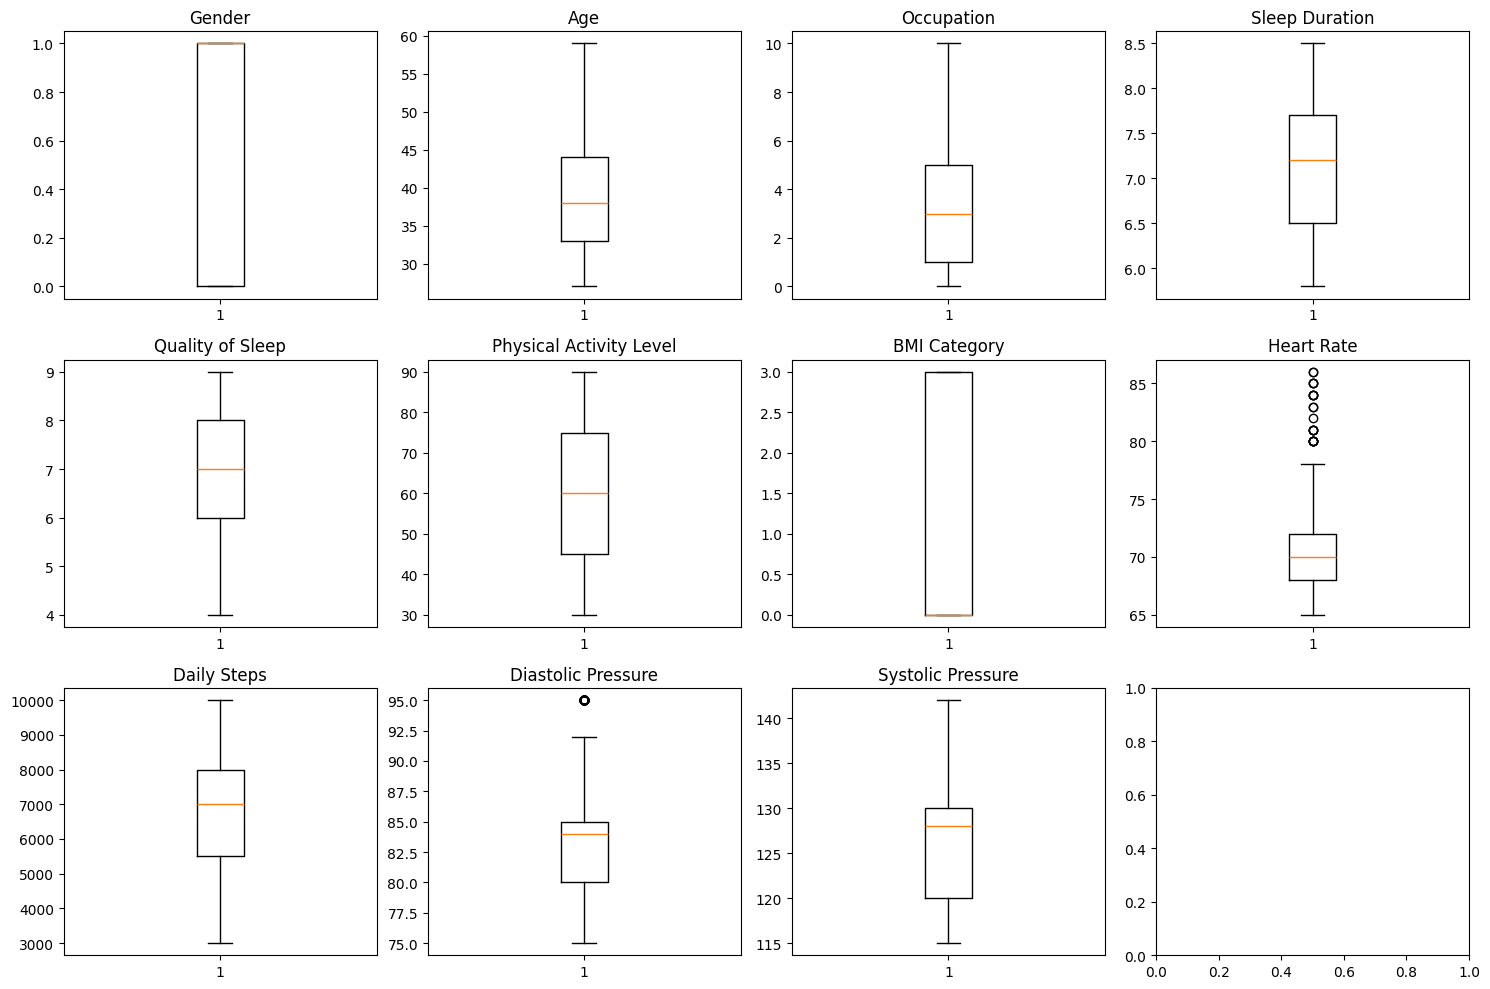

In [16]:
boxplot(df)

## Correlation analysis

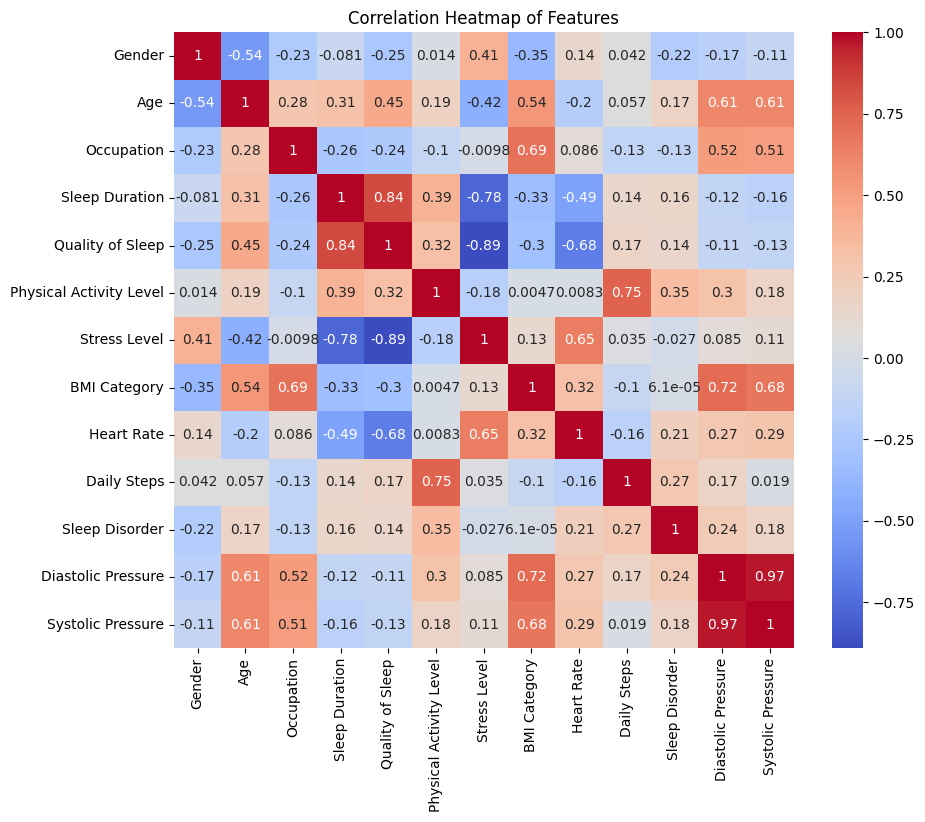

In [17]:
correlation_analysis(df)

## Analysis
The correlation heatmap provides insights into the relationships between different features in the dataset
From the above heatmap, we can see that :-
- Systolic and Diastolic Pressures are highly correlated (+ve)
- Quality of Sleep and Sleep duration (+ve )
- Stress level and Quality of sleep / Sleep duaration (-ve)
- Daily steps and physical activity level (+ve)

# Standardisation of Data

In [18]:
# Standardize the data
df = standardise(df)
df

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,Diastolic Pressure,Systolic Pressure
0,0.866025,-1.602659,1.838105,-1.369144,-1.124718,-0.842003,6,1.451718,1.762740,-1.717495,1,-0.083242,-0.131326
1,0.866025,-1.479581,-0.795317,-1.234372,-1.124718,0.060815,8,-0.755419,1.245916,2.083039,1,-0.603121,-0.263836
2,0.866025,-1.479581,-0.795317,-1.234372,-1.124718,0.060815,8,-0.755419,1.245916,2.083039,1,-0.603121,-0.263836
3,0.866025,-1.479581,0.850572,-1.638689,-2.888981,-1.443882,8,0.716006,3.830037,-2.503813,2,1.129807,1.723805
4,0.866025,-1.479581,0.850572,-1.638689,-2.888981,-1.443882,8,0.716006,3.830037,-2.503813,2,1.129807,1.723805
...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,-1.154701,0.366598,2.167283,-0.560509,-0.242586,-0.691534,4,1.451718,-1.338206,-0.538019,0,1.129807,1.061258
182,0.866025,0.366598,1.179749,-0.830054,-1.124718,-0.691534,7,1.451718,0.470679,-0.538019,0,0.263343,0.398711
183,-1.154701,0.366598,2.167283,-0.560509,-0.242586,-0.691534,4,1.451718,-1.338206,-0.538019,0,1.129807,1.061258
184,0.866025,0.366598,1.179749,-0.964827,-1.124718,-0.691534,7,1.451718,0.470679,-0.538019,0,0.263343,0.398711


# Building Regression models for Stress level Prediction

In [19]:
# Regression
tgt1 = df["Stress Level"]
feat1 = df.drop(columns=["Stress Level", "Sleep Disorder"])

In [20]:
scoreList = get_training_scores(df)

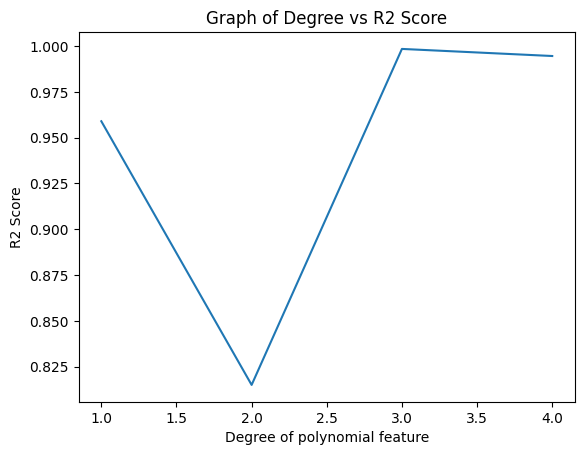

In [21]:
regression_results(scoreList)

# From the above plot, we select the degree of polynomial features as 3

In [22]:
regress_linear(feat1, tgt1)

r2_score = 0.9984189316572516
mean_squared_error = 0.004713761663699081


## Classification

In [23]:
X = df.drop(columns=["Stress Level", "Sleep Disorder"])
y = df["Sleep Disorder"]

# Building Models for Classification of Sleep Disorders

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

Classification Accuracy: 0.9464285714285714
Classification Report               precision    recall  f1-score   support

           0       0.96      0.81      0.88        27
           1       0.96      0.99      0.98       111
           2       0.87      0.90      0.89        30

    accuracy                           0.95       168
   macro avg       0.93      0.90      0.91       168
weighted avg       0.95      0.95      0.95       168



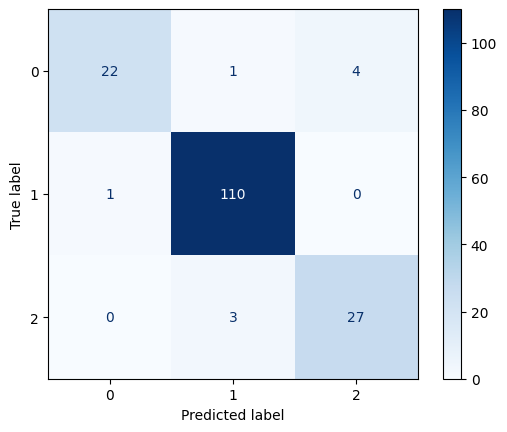

In [25]:
classify_svc(X_train, y_train, X_test, y_test, kernel="linear")

# Using over sampling method SMOTE to balance the data

In [26]:
# Checking for imbalanced data
cc = Counter(y_train)
cc

Counter({1: 264, 0: 66, 2: 62})

In [27]:
# Bad news, we actually have a large amount of imbalanced data
# So using a imbalanced learn method helps us to predict good observations
# Using SMOTE: Synthetic Minority Oversampling Technique


X_smote, y_smote = resample_smote(X_train, y_train)

In [28]:
cc = Counter(y_smote)
cc

Counter({1: 264, 2: 264, 0: 264})

## Using Undersampling Method

In [29]:
X_clc, y_clc = resample_cc(X_train, y_train)

/media/shanmukha/DATA/Projects/personal_projects/ML-Project/.venv/lib/python3.12/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (27) found smaller than n_clusters (62). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


In [30]:
X_clc, y_clc = resample_iht(X_train, y_train)

In [31]:
cc = Counter(y_clc)
cc

Counter({1: 135, 0: 66, 2: 62})

# Using Randomized search CV

## Initial Data

In [32]:
gammaValues = ["scale", "auto"]
param_grid = {
    "kernel": ["linear", "rbf", "poly"],
    "C": uniform(1e-5, 10),
    "degree": [i for i in range(1, 20)],
    "gamma": gammaValues,
    "decision_function_shape": ["ovo", "ovr"],
}

In [33]:
rand_clf = run_randomised_search_svc(X_train, y_train, param_grid)

In [34]:
rand_clf.best_params_

{'C': np.float64(5.211329411064671),
 'decision_function_shape': 'ovr',
 'degree': 5,
 'gamma': 'auto',
 'kernel': 'rbf'}

In [35]:
# Printing the classification report for the randomized search hyper parameter tuned model
y_pred = rand_clf.predict(X_test)

print(
    "The classification report after using randomized search CV\n",
    classification_report(y_test, y_pred),
)

The classification report after using randomized search CV
               precision    recall  f1-score   support

           0       0.88      0.85      0.87        27
           1       0.96      0.99      0.98       111
           2       0.89      0.83      0.86        30

    accuracy                           0.94       168
   macro avg       0.91      0.89      0.90       168
weighted avg       0.94      0.94      0.94       168



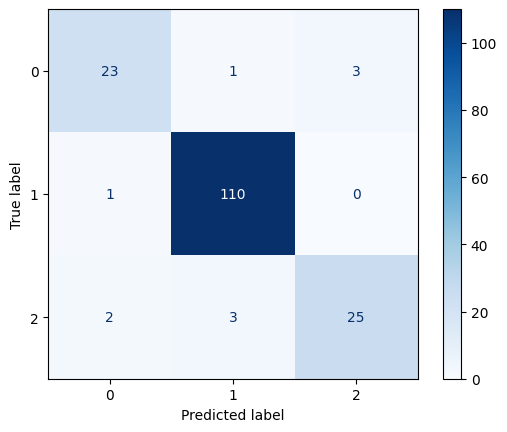

In [36]:
# Printing the confusion matrix for the randomized search hyper parameter tuned model
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(cmap=plt.cm.Blues)

# Randomized search CV for SMOTE

In [37]:
rand_clf = run_randomised_search_svc(X_smote, y_smote, param_grid)

In [38]:
rand_clf.best_params_

{'C': np.float64(7.6105424380255915),
 'decision_function_shape': 'ovr',
 'degree': 14,
 'gamma': 'scale',
 'kernel': 'rbf'}

In [39]:
# Printing the classification report for the randomized search hyper parameter tuned model

y_pred = rand_clf.predict(X_test)

print(
    "The classification report after using randomized search CV\n",
    classification_report(y_test, y_pred),
)

The classification report after using randomized search CV
               precision    recall  f1-score   support

           0       0.88      0.85      0.87        27
           1       0.96      0.99      0.98       111
           2       0.89      0.83      0.86        30

    accuracy                           0.94       168
   macro avg       0.91      0.89      0.90       168
weighted avg       0.94      0.94      0.94       168



In [40]:
confusion_matrix(y_test, y_pred)

array([[ 23,   1,   3],
       [  1, 110,   0],
       [  2,   3,  25]])

# RandomizedSearchCV for Under Sampled Data

In [41]:
rand_clf = run_randomised_search_svc(X_clc, y_clc, param_grid)

In [42]:
rand_clf.best_params_

{'C': np.float64(7.722954895465229),
 'decision_function_shape': 'ovo',
 'degree': 19,
 'gamma': 'scale',
 'kernel': 'rbf'}

In [43]:
y_pred = rand_clf.predict(X_test)

print(
    "The classification report after using randomized search CV\n",
    classification_report(y_test, y_pred),
)

The classification report after using randomized search CV
               precision    recall  f1-score   support

           0       0.74      0.85      0.79        27
           1       0.96      0.92      0.94       111
           2       0.81      0.83      0.82        30

    accuracy                           0.89       168
   macro avg       0.84      0.87      0.85       168
weighted avg       0.90      0.89      0.89       168



In [44]:
confusion_matrix(y_test, y_pred)

array([[ 23,   1,   3],
       [  6, 102,   3],
       [  2,   3,  25]])

# Using GridSearchCV for hyper parameter tuning

In [45]:
gammaValues = ["scale", "auto"]
cvals = [1e-5, 1e-4, 1e-3, 0.01, 0.1, 1, 10]
param_grid = {
    "kernel": ["linear", "rbf", "poly"],
    "C": cvals,
    "degree": [i for i in range(1, 5)],
    "gamma": gammaValues,
    "decision_function_shape": ["ovo", "ovr"],
}

In [46]:
grid_clf = run_grid_search_svc(X_train, y_train, param_grid)

Fitting 5 folds for each of 336 candidates, totalling 1680 fits
[CV 1/5] END C=1e-05, decision_function_shape=ovo, degree=1, gamma=scale, kernel=linear;, score=0.671 total time=   0.0s
[CV 2/5] END C=1e-05, decision_function_shape=ovo, degree=1, gamma=scale, kernel=linear;, score=0.671 total time=   0.0s
[CV 3/5] END C=1e-05, decision_function_shape=ovo, degree=1, gamma=scale, kernel=linear;, score=0.679 total time=   0.0s
[CV 4/5] END C=1e-05, decision_function_shape=ovo, degree=1, gamma=scale, kernel=linear;, score=0.679 total time=   0.0s
[CV 5/5] END C=1e-05, decision_function_shape=ovo, degree=1, gamma=scale, kernel=linear;, score=0.667 total time=   0.0s
[CV 1/5] END C=1e-05, decision_function_shape=ovo, degree=1, gamma=scale, kernel=rbf;, score=0.671 total time=   0.0s
[CV 2/5] END C=1e-05, decision_function_shape=ovo, degree=1, gamma=scale, kernel=rbf;, score=0.671 total time=   0.0s
[CV 3/5] END C=1e-05, decision_function_shape=ovo, degree=1, gamma=scale, kernel=rbf;, score=0.

In [47]:
# Finding the best parameters for the gridsearch CV
grid_clf.best_params_

{'C': 10,
 'decision_function_shape': 'ovo',
 'degree': 1,
 'gamma': 'scale',
 'kernel': 'rbf'}

In [48]:
# Using the test data to make predictions on the input
y_pred = grid_clf.predict(X_test)
print(
    "Classification Report after using grid search CV\n",
    classification_report(y_pred=y_pred, y_true=y_test),
)

Classification Report after using grid search CV
               precision    recall  f1-score   support

           0       0.88      0.85      0.87        27
           1       0.96      0.99      0.98       111
           2       0.89      0.83      0.86        30

    accuracy                           0.94       168
   macro avg       0.91      0.89      0.90       168
weighted avg       0.94      0.94      0.94       168



In [49]:
print("The confusion matrix is as follows")
confusion_matrix(y_test, y_pred)

The confusion matrix is as follows


array([[ 23,   1,   3],
       [  1, 110,   0],
       [  2,   3,  25]])

## Using SMOTE samples for GridSearchCV


In [50]:
grid_clf = run_grid_search_svc(X_smote, y_smote, param_grid)

Fitting 5 folds for each of 336 candidates, totalling 1680 fits
[CV 1/5] END C=1e-05, decision_function_shape=ovo, degree=1, gamma=scale, kernel=linear;, score=0.811 total time=   0.0s
[CV 2/5] END C=1e-05, decision_function_shape=ovo, degree=1, gamma=scale, kernel=linear;, score=0.780 total time=   0.0s
[CV 3/5] END C=1e-05, decision_function_shape=ovo, degree=1, gamma=scale, kernel=linear;, score=0.329 total time=   0.0s
[CV 4/5] END C=1e-05, decision_function_shape=ovo, degree=1, gamma=scale, kernel=linear;, score=0.329 total time=   0.0s
[CV 5/5] END C=1e-05, decision_function_shape=ovo, degree=1, gamma=scale, kernel=linear;, score=0.329 total time=   0.0s
[CV 1/5] END C=1e-05, decision_function_shape=ovo, degree=1, gamma=scale, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/5] END C=1e-05, decision_function_shape=ovo, degree=1, gamma=scale, kernel=rbf;, score=0.824 total time=   0.0s
[CV 3/5] END C=1e-05, decision_function_shape=ovo, degree=1, gamma=scale, kernel=rbf;, score=0.

In [51]:
grid_clf.best_params_

{'C': 10,
 'decision_function_shape': 'ovo',
 'degree': 1,
 'gamma': 'auto',
 'kernel': 'rbf'}

In [52]:
y_pred = grid_clf.predict(X_test)
print(
    "Classification Report after using grid search CV on SMOTE data\n",
    classification_report(y_pred=y_pred, y_true=y_test),
)

Classification Report after using grid search CV on SMOTE data
               precision    recall  f1-score   support

           0       0.88      0.85      0.87        27
           1       0.96      0.98      0.97       111
           2       0.86      0.83      0.85        30

    accuracy                           0.93       168
   macro avg       0.90      0.89      0.90       168
weighted avg       0.93      0.93      0.93       168



In [53]:
confusion_matrix(y_pred=y_pred, y_true=y_test)

array([[ 23,   1,   3],
       [  1, 109,   1],
       [  2,   3,  25]])

# Using GridSearchCV for Under Sampled data

In [54]:
grid_clf = run_grid_search_svc(X_clc, y_clc, param_grid)

Fitting 5 folds for each of 336 candidates, totalling 1680 fits
[CV 1/5] END C=1e-05, decision_function_shape=ovo, degree=1, gamma=scale, kernel=linear;, score=0.509 total time=   0.0s
[CV 2/5] END C=1e-05, decision_function_shape=ovo, degree=1, gamma=scale, kernel=linear;, score=0.509 total time=   0.0s
[CV 3/5] END C=1e-05, decision_function_shape=ovo, degree=1, gamma=scale, kernel=linear;, score=0.509 total time=   0.0s
[CV 4/5] END C=1e-05, decision_function_shape=ovo, degree=1, gamma=scale, kernel=linear;, score=0.519 total time=   0.0s
[CV 5/5] END C=1e-05, decision_function_shape=ovo, degree=1, gamma=scale, kernel=linear;, score=0.519 total time=   0.0s
[CV 1/5] END C=1e-05, decision_function_shape=ovo, degree=1, gamma=scale, kernel=rbf;, score=0.509 total time=   0.0s
[CV 2/5] END C=1e-05, decision_function_shape=ovo, degree=1, gamma=scale, kernel=rbf;, score=0.509 total time=   0.0s
[CV 3/5] END C=1e-05, decision_function_shape=ovo, degree=1, gamma=scale, kernel=rbf;, score=0.

In [55]:
grid_clf.best_params_

{'C': 0.1,
 'decision_function_shape': 'ovo',
 'degree': 1,
 'gamma': 'scale',
 'kernel': 'linear'}

In [56]:
y_pred = grid_clf.predict(X_test)
print(
    "Classification Report after using grid search CV on SMOTE data\n",
    classification_report(y_pred=y_pred, y_true=y_test),
)

Classification Report after using grid search CV on SMOTE data
               precision    recall  f1-score   support

           0       0.81      0.78      0.79        27
           1       0.96      0.92      0.94       111
           2       0.75      0.90      0.82        30

    accuracy                           0.89       168
   macro avg       0.84      0.87      0.85       168
weighted avg       0.90      0.89      0.89       168



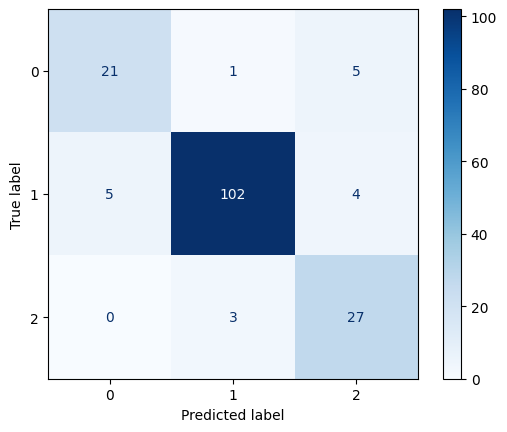

In [57]:
ConfusionMatrixDisplay(confusion_matrix(y_true=y_test, y_pred=y_pred)).plot(
    cmap=plt.cm.Blues
)

# Visualising clusters using Principal Component Analysis (PCA and Kernel PCA)

In [58]:
label_encoding_dict["Sleep Disorder"].classes_

array(['Insomnia', 'None', 'Sleep Apnea'], dtype=object)

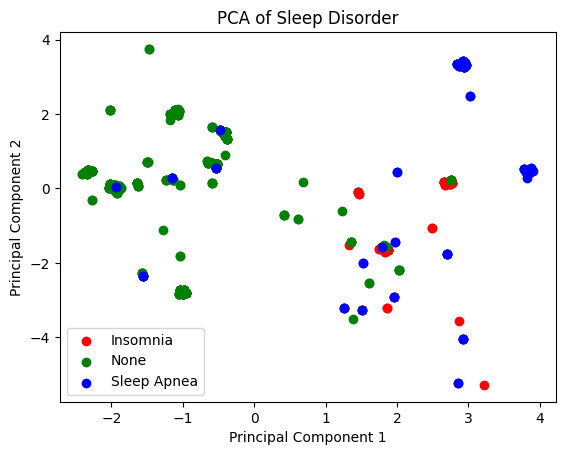

In [59]:
pca, df_full_pca = do_pca(df)

plot_pca(df_full_pca, df, label_encoding_dict)

## Visualising Explained Variance Ratio vs Number of Components, & finding the optimal number of components

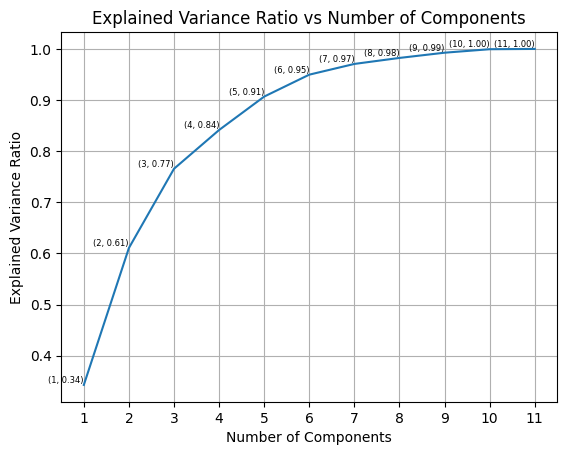

In [60]:
plot_variance_ratio(pca)

## From here we can see that at Number of Components = 5, it has achieved 91% of cumulative variance ratio. So we would try the classification using the new 5 components

In [61]:
new_pca, new_points = get_new_components(df)

Classification Accuracy: 0.9404761904761905
Classification Report               precision    recall  f1-score   support

           0       0.88      0.85      0.87        27
           1       0.96      0.99      0.98       111
           2       0.89      0.83      0.86        30

    accuracy                           0.94       168
   macro avg       0.91      0.89      0.90       168
weighted avg       0.94      0.94      0.94       168



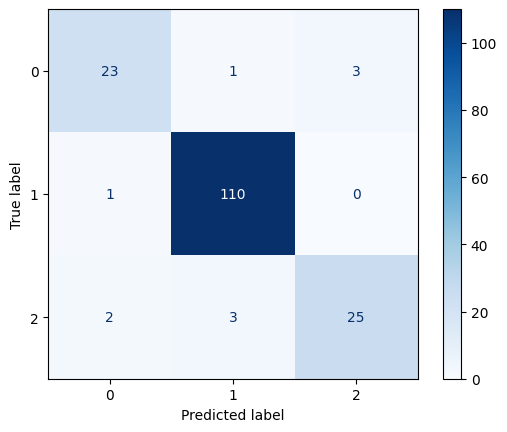

In [62]:
X = df.drop(columns=["Stress Level", "Sleep Disorder"])
y = df["Sleep Disorder"]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

classify_svc(
    X_train,
    y_train,
    X_test,
    y_test,
    kernel="rbf",
    degree=4,
    C=8.430136277531556,
    gamma="auto",
    decision_function_shape="ovr",
)

# using ensemble methods for imporving accuracy and reduce overfitting


In [63]:
y2 = df["Sleep Disorder"]
y = df["Stress Level"]

# Ensembles for Regression

In [64]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

regress_bagging(X_train, y_train, X_test, y_test)

mean squared error 0.04088792197122395


In [65]:
# Calculate the differences (residuals)
residuals, y_pred_reg = regress_rf(X_train, y_train, X_test, y_test)

mean squared error:  0.017291666666666657
r2-score:  0.9938278256250711


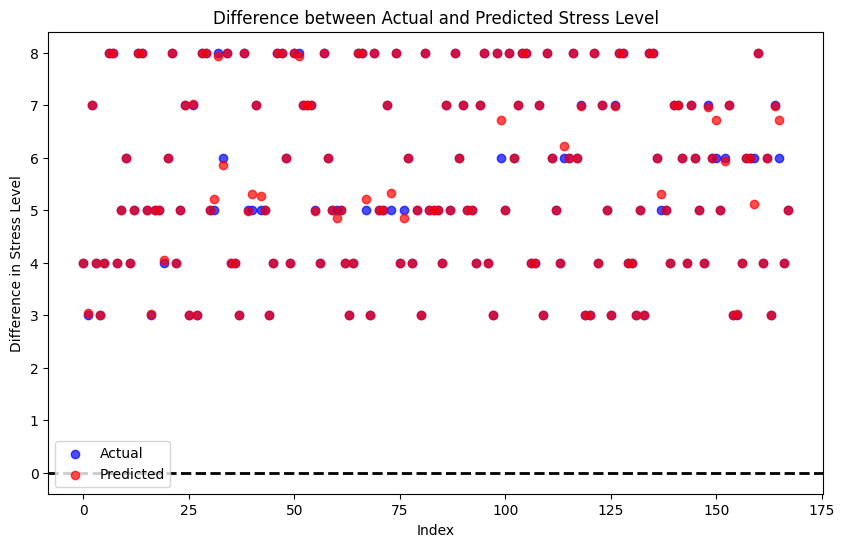

In [66]:
plot_residual(y_test, y_pred_reg, residuals)

# classification using Ensembles

In [67]:
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X, y2, test_size=0.2, random_state=42
)

Classification Accuracy: 0.9464285714285714
Classification Report               precision    recall  f1-score   support

           0       0.94      0.88      0.91        17
           1       0.95      0.99      0.97        74
           2       0.95      0.86      0.90        21

    accuracy                           0.95       112
   macro avg       0.94      0.91      0.93       112
weighted avg       0.95      0.95      0.95       112



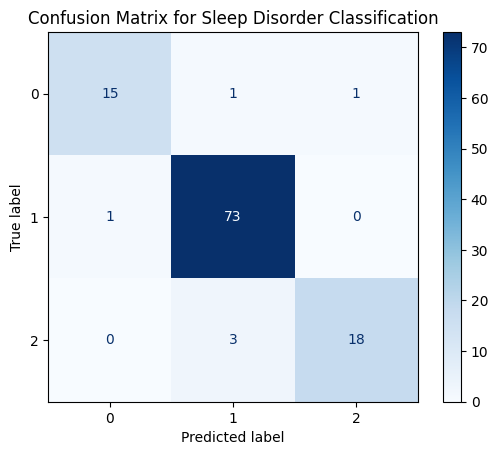

In [68]:
classify_rf(X_train_clf, y_train_clf, X_test_clf, y_test_clf)
plt.title("Confusion Matrix for Sleep Disorder Classification")
plt.show()

## Finding the best n_estimators for Random Forest Classifier


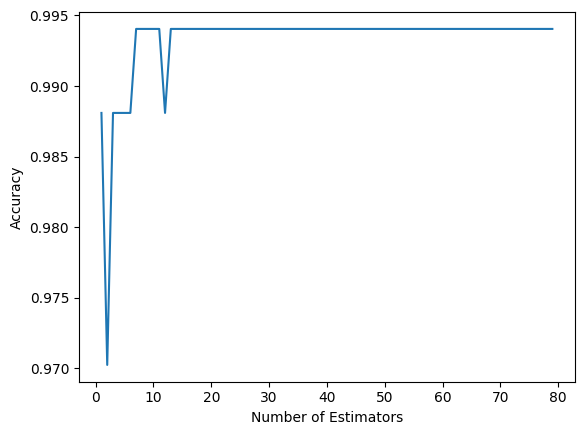

In [69]:
plot_rfc(X_train, y_train, X_test, y_test)

Random Forest Regressor - MSE: 0.0031, R2 Score: 0.9989


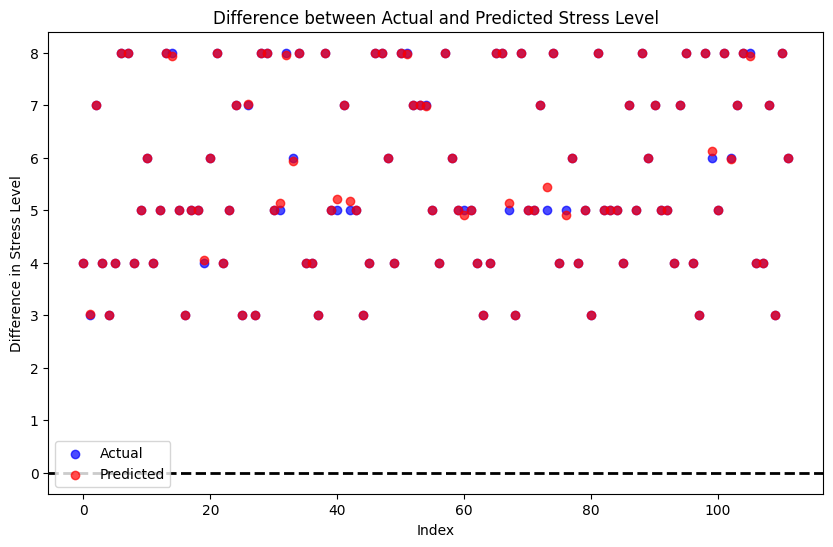

Gradient Boosting Regressor - MSE: 0.0034, R2 Score: 0.9988


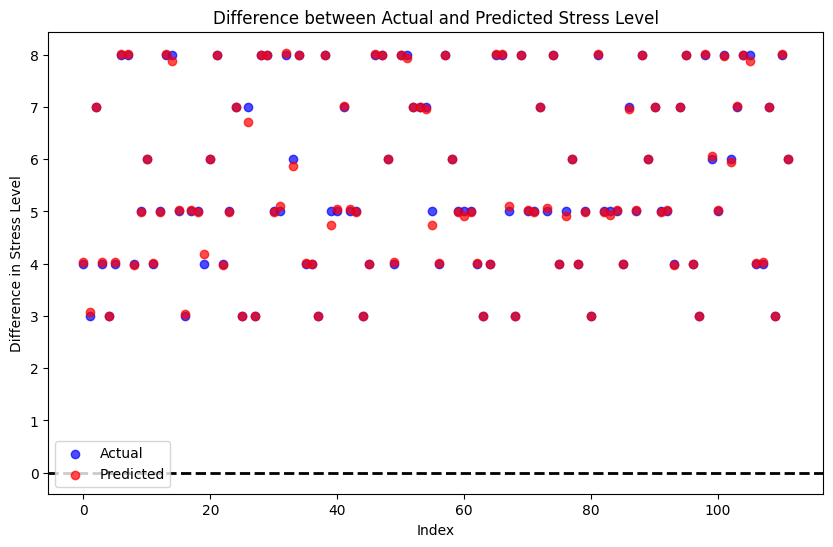

AdaBoost Regressor - MSE: 0.1363, R2 Score: 0.9534


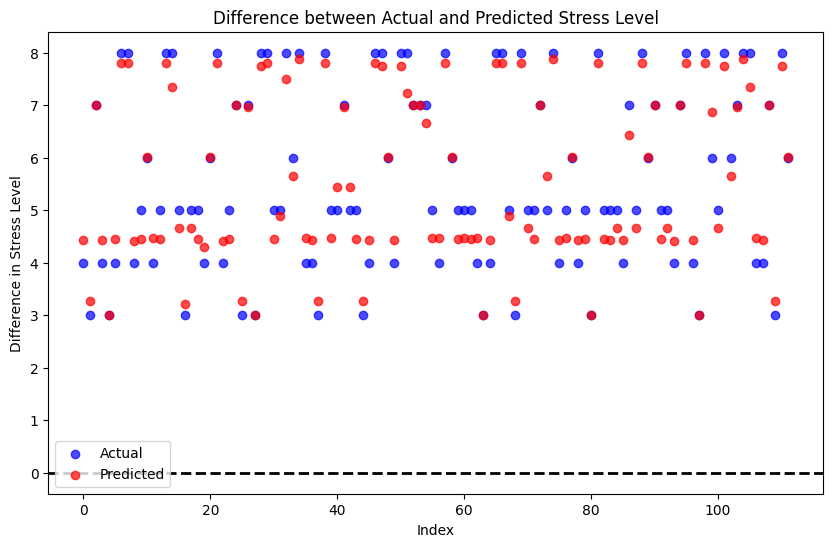

Bagging Regressor - MSE: 0.0104, R2 Score: 0.9964


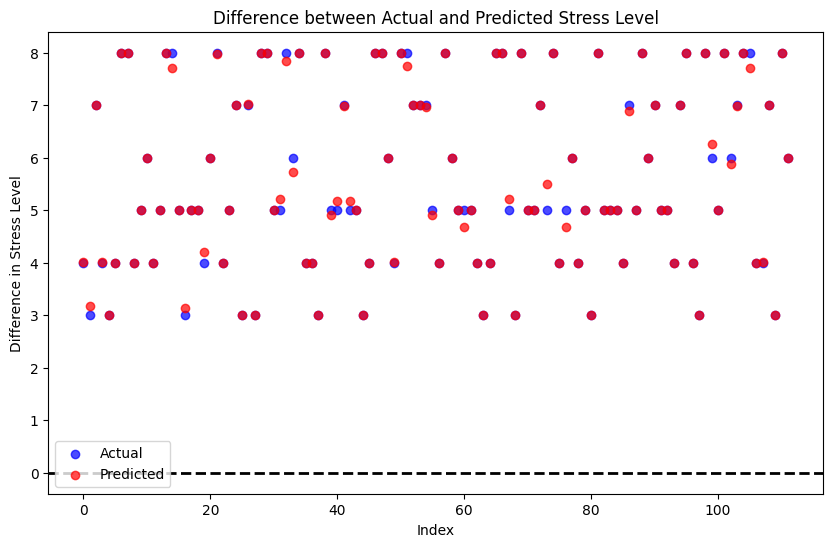

XGBoost Regressor - MSE: 0.0001, R2 Score: 1.0000


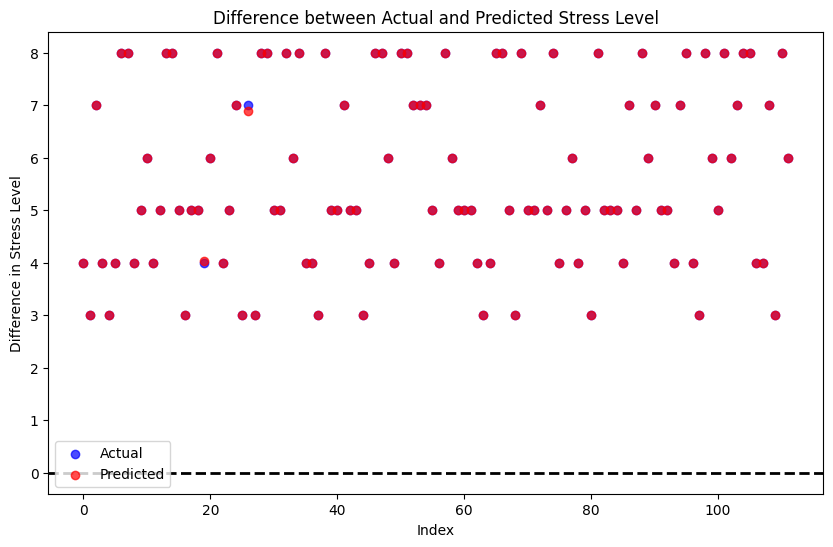

In [70]:
# Split the data into training and testing sets
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define and train ensemble regressors
regressors = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "Bagging": BaggingRegressor(estimator=RandomForestRegressor(), random_state=42),
    "XGBoost": XGBRegressor(objective="reg:squarederror", random_state=42),
}

compare_regs(X_train_reg, y_train_reg, X_test_reg, y_test_reg, regressors)

### The best Ensemble Regressor is XG Boost

In [75]:
get_top_features(regressors['XGBoost'], X_train_reg.columns.to_list())

,feature,importance
4,Quality of Sleep,0.849159
7,Heart Rate,0.062866
3,Sleep Duration,0.040557
8,Daily Steps,0.026509
5,Physical Activity Level,0.008682
2,Occupation,0.005208
1,Age,0.004907
0,Gender,0.001525
6,BMI Category,0.000444
9,Diastolic Pressure,0.000115


Random Forest Classifier - Accuracy: 0.9464


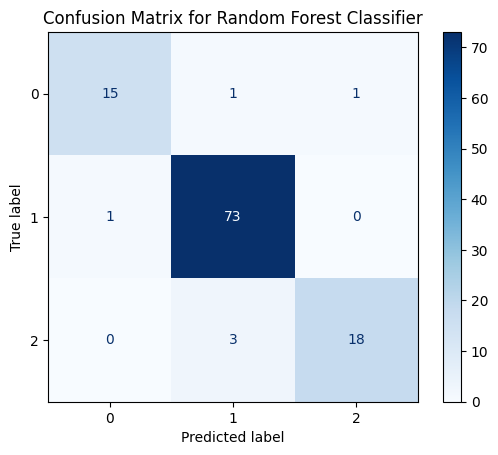

Gradient Boosting Classifier - Accuracy: 0.9464


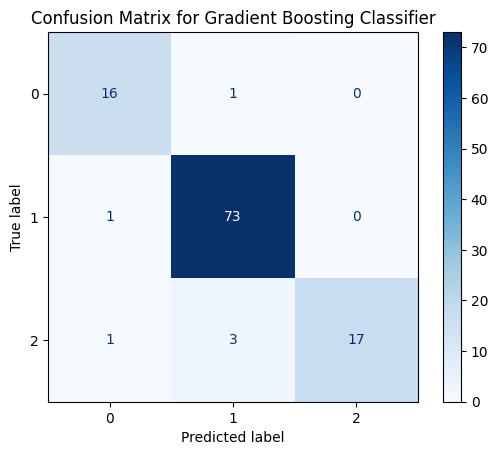

AdaBoost Classifier - Accuracy: 0.9018


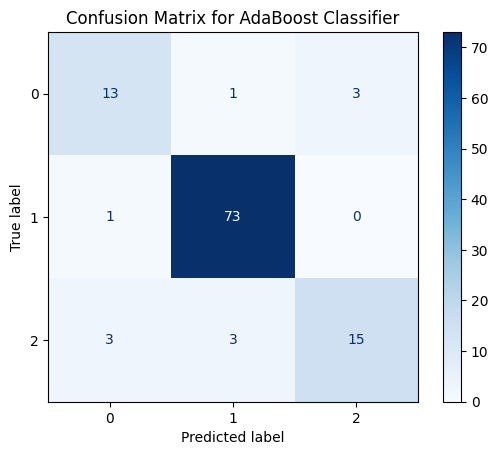

Bagging Classifier - Accuracy: 0.9375


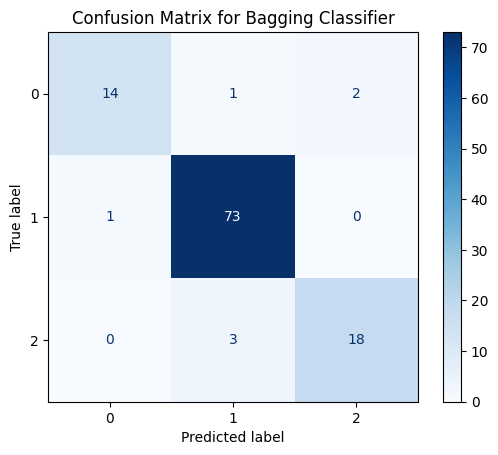

XGBoost Classifier - Accuracy: 0.9464


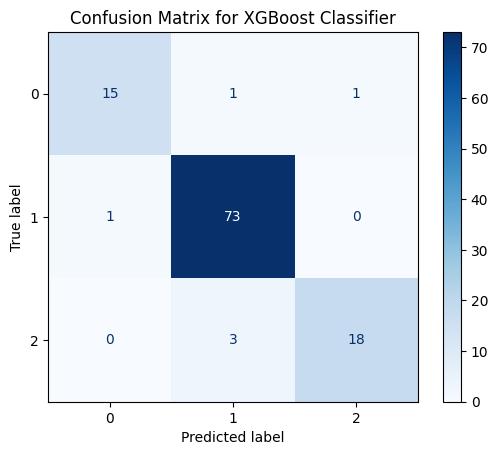

In [76]:
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X, y2, test_size=0.2, random_state=42
)

# Define and train ensemble classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(n_estimators=40, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Bagging": BaggingClassifier(estimator=RandomForestClassifier(), random_state=42),
    "XGBoost": XGBClassifier(eval_metric="logloss", random_state=42),
}

# Evaluate each classifier
compare_clf(X_train_clf, y_train_clf, X_test_clf, y_test_clf, classifiers)

## The best Ensemble Classifier are Random Forest, Gradient Boosting and XG Boost

In [77]:
get_top_features(classifiers['Random Forest'], X_train_clf.columns.to_list())

,feature,importance
6,BMI Category,0.222395
9,Diastolic Pressure,0.164485
2,Occupation,0.131653
3,Sleep Duration,0.110664
10,Systolic Pressure,0.106363
1,Age,0.085269
7,Heart Rate,0.061939
5,Physical Activity Level,0.050961
8,Daily Steps,0.038474
4,Quality of Sleep,0.020672


# precision recall graphs


In [78]:
y = df["Sleep Disorder"]
# Use label_binarize to be multi-label like settings
Y = label_binarize(y, classes=[0, 1, 2])
n_classes = Y.shape[1]

# Split into training and test
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

classifier = OneVsRestClassifier(make_pipeline(StandardScaler(), SVC(random_state=42)))
classifier.fit(X_train2, Y_train2)
y_score = classifier.decision_function(X_test2)

In [79]:
precision, recall, avg_precision = compute_prec_recall(Y_test2, y_score, n_classes=3)

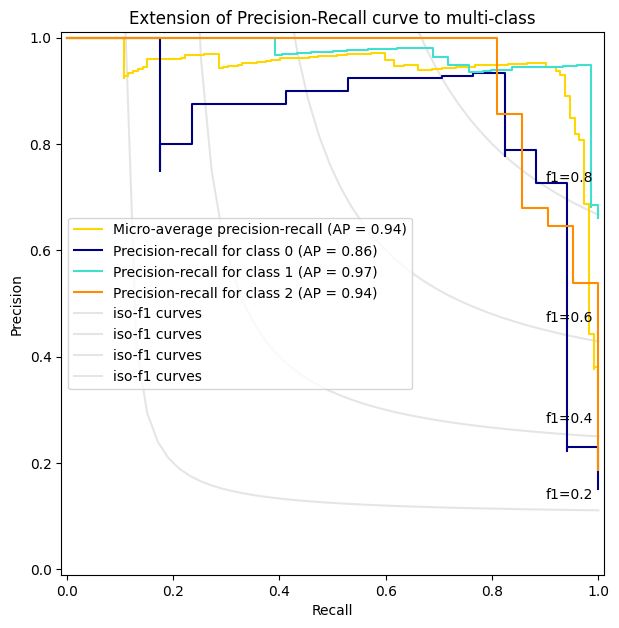

In [80]:
plot_prec_recall(precision, recall, avg_precision, n_classes=3)

On a final note:
1. Sleep disorder is highly affected by BMI category
2. Stress level is extremely affected by level of sleep 